# ACRO Demonstration

In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
# uncomment this line if acro is not installed
# ie you are in development mode
# sys.path.insert(0, os.path.abspath(".."))

In [3]:
from acro import ACRO, add_constant, add_to_acro

### Instantiate ACRO

In [4]:
acro = ACRO(suppress=True)

INFO:acro:version: 0.4.8
INFO:acro:config: {'safe_threshold': 10, 'safe_dof_threshold': 10, 'safe_nk_n': 2, 'safe_nk_k': 0.9, 'safe_pratio_p': 0.1, 'check_missing_values': False, 'survival_safe_threshold': 10, 'zeros_are_disclosive': True}
INFO:acro:automatic suppression: True


### Load test data
The dataset used in this notebook is the nursery dataset from OpenML.  
- The dataset can be read directly from OpenML using the code commented in the next cell.
- In this version, it can be read directly from the local machine if it has been downloaded. 
- The code below reads the data from a folder called "data" which we assume is at the same level as the folder where you are working.
- The path might need to be changed if the data has been downloaded and stored elsewhere.
 - for example use:  
    path = os.path.join("data", "nursery.arff")  
    if the data is in a sub-folder of your work folder

In [5]:
from scipy.io.arff import loadarff

path = os.path.join("../data", "nursery.arff")
data = loadarff(path)
df = pd.DataFrame(data[0])
df = df.select_dtypes([object])
df = df.stack().str.decode("utf-8").unstack()
df.rename(columns={"class": "recommend"}, inplace=True)
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


### Convert 'more than 3' children to random between 4 and 10
Change the children column from categorical to numeric in order to be able to test some of the ACRO functions that require a numeric feature

In [6]:
print(f" children column entries in raw file {df.children.unique()}")

 children column entries in raw file ['1' '2' '3' 'more']


In [7]:
df["children"].replace(to_replace={"more": "4"}, inplace=True)
df["children"] = pd.to_numeric(df["children"])

df["children"] = df.apply(
    lambda row: (
        row["children"] if row["children"] in (1, 2, 3) else np.random.randint(4, 10)
    ),
    axis=1,
)

# Examples of producing tabular output
We rely on the industry-standard package **pandas** for tabulating data.  
In the next few examples we show:
- first, how a researcher would normally make a call in pandas, saving the results in a variable that they can view on screen (or save to file?)
- then how the call is identical in SACRO, except that:
  - "pd" is replaced by "acro"
  - the researcher immediately sees a copy of what the TRE output checker will see.
  

### Pandas crosstab
This is an example of crosstab using pandas.  
We first make the call, then the second line print the outputs to screen.

In [8]:
table = pd.crosstab(df.recommend, df.parents)
print(table)

parents     great_pret  pretentious  usual
recommend                                 
not_recom         1440         1440   1440
priority           858         1484   1924
recommend            0            0      2
spec_prior        2022         1264    758
very_recom           0          132    196


### ACRO crosstab
This is an example of crosstab using ACRO.  
The INFO lines show the researcher what will be reported to the output checkers.
Then the (suppressed as necessary)  table is shown via. the print command as before.

In [9]:
safe_table = acro.crosstab(
    df.recommend,
    df.parents,
)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 4 cells suppressed; 
INFO:acro:outcome_df:
----------------------------------------------------|
parents    |great_pret   |pretentious  |usual       |
recommend  |             |             |            |
----------------------------------------------------|
not_recom  |          ok |          ok |          ok|
priority   |          ok |          ok |          ok|
recommend  | threshold;  | threshold;  | threshold; |
spec_prior |          ok |          ok |          ok|
very_recom | threshold;  |          ok |          ok|
----------------------------------------------------|

INFO:acro:records:add(): output_0


parents     great_pret  pretentious   usual
recommend                                  
not_recom       1440.0       1440.0  1440.0
priority         858.0       1484.0  1924.0
recommend          NaN          NaN     NaN
spec_prior      2022.0       1264.0   758.0
very_recom         NaN        132.0   196.0


### ACRO crosstab with totals
This is an example of crosstab with totals columns and suppression.  
Note that when margins is true any row or column where all the cells are discolsive is deleted. If you wish to see such row or column set show_suppressed to True.  
show_suppressed parameter does not work with herichical tables and when the aggregation function is the standard deviation.

In [10]:
safe_table = acro.crosstab(df.recommend, df.parents, margins=True)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 5 cells suppressed; 
INFO:acro:outcome_df:
------------------------------------------------------------------|
parents    |great_pret   |pretentious  |usual        |All         |
recommend  |             |             |             |            |
------------------------------------------------------------------|
not_recom  |          ok |          ok |          ok |          ok|
priority   |          ok |          ok |          ok |          ok|
recommend  | threshold;  | threshold;  | threshold;  | threshold; |
spec_prior |          ok |          ok |          ok |          ok|
very_recom | threshold;  |          ok |          ok |          ok|
All        |          ok |          ok |          ok |          ok|
------------------------------------------------------------------|

INFO:acro:records:add(): output_1


parents     great_pret  pretentious  usual    All
recommend                                        
not_recom       1440.0         1440   1440   4320
priority         858.0         1484   1924   4266
spec_prior      2022.0         1264    758   4044
very_recom         NaN          132    196    328
All             4320.0         4320   4318  12958


### ACRO crosstab without suppression
This is an example of crosstab without suppressing the cells that violate the disclosure tests.  
Note that you need to change the value of the suppress variable in the acro object to False. Then run the crosstab command.  
If you wish to continue the research while suppressing the outputs, turn on the suppress variable otherwise leave it as it is.

In [11]:
acro.suppress = False

safe_table = acro.crosstab(df.recommend, df.parents)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 4 cells may need suppressing; 
INFO:acro:outcome_df:
----------------------------------------------------|
parents    |great_pret   |pretentious  |usual       |
recommend  |             |             |            |
----------------------------------------------------|
not_recom  |          ok |          ok |          ok|
priority   |          ok |          ok |          ok|
recommend  | threshold;  | threshold;  | threshold; |
spec_prior |          ok |          ok |          ok|
very_recom | threshold;  |          ok |          ok|
----------------------------------------------------|

INFO:acro:records:add(): output_2


parents     great_pret  pretentious  usual
recommend                                 
not_recom         1440         1440   1440
priority           858         1484   1924
recommend            0            0      2
spec_prior        2022         1264    758
very_recom           0          132    196


In [12]:
acro.suppress = True

### ACRO crosstab with aggregation function

In [13]:
safe_table = acro.crosstab(
    df.recommend, df.parents, values=df.children, aggfunc="count"
)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 1 cells suppressed; p-ratio: 4 cells suppressed; nk-rule: 4 cells suppressed; 
INFO:acro:outcome_df:
------------------------------------------------------------------------------------|
parents    |great_pret          |pretentious         |usual                         |
recommend  |                    |                    |                              |
------------------------------------------------------------------------------------|
not_recom  |                 ok |                 ok |                            ok|
priority   |                 ok |                 ok |                            ok|
recommend  | p-ratio; nk-rule;  | p-ratio; nk-rule;  | threshold; p-ratio; nk-rule; |
spec_prior |                 ok |                 ok |                            ok|
very_recom | p-ratio; nk-rule;  |                 ok |                            ok|
-----------------------------------------------------------------------------------

parents     great_pret  pretentious   usual
recommend                                  
not_recom       1440.0       1440.0  1440.0
priority         858.0       1484.0  1924.0
recommend          NaN          NaN     NaN
spec_prior      2022.0       1264.0   758.0
very_recom         NaN        132.0   196.0


In [14]:
safe_table = acro.crosstab(
    df.recommend, df.parents, values=df.children, aggfunc=["mode", "mean"]
)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 2 cells suppressed; p-ratio: 8 cells suppressed; nk-rule: 8 cells suppressed; 
INFO:acro:outcome_df:
---------------------------------------------------------------------------------------------------------------------------------------------------------|
           mode_aggfunc                                                           |mean                                                                  |
parents    great_pret          pretentious         usual                          |great_pret          pretentious         usual                         |
recommend                                                                         |                                                                      |
---------------------------------------------------------------------------------------------------------------------------------------------------------|
not_recom                   ok                  ok                             ok 

           mode_aggfunc                         mean                      
parents      great_pret pretentious usual great_pret pretentious     usual
recommend                                                                 
not_recom           2.0         1.0   1.0   3.125694    3.105556  3.074306
priority            1.0         1.0   1.0   2.665501    3.030323  3.116944
recommend           NaN         NaN   NaN        NaN         NaN       NaN
spec_prior          3.0         3.0   3.0   3.353610    3.370253  3.393140
very_recom          NaN         1.0   1.0        NaN    2.204545  2.244898


### ACRO pivot_table
This is an example of pivot table using ACRO.  
- Some researchers may prefer this to using crosstab.   
- Again the call syntax is identical to the pandas "pd.pivot_table"
- in this case the output is non-disclosive

In [15]:
table = acro.pivot_table(
    df, index=["parents"], values=["children"], aggfunc=["mean", "std"]
)
print(table)

INFO:acro:get_summary(): pass
INFO:acro:outcome_df:
------------------------------|
            mean     |std     |
            children |children|
parents              |        |
------------------------------|
great_pret   ok      | ok     |
pretentious  ok      | ok     |
usual        ok      | ok     |
------------------------------|

INFO:acro:records:add(): output_5


                 mean       std
             children  children
parents                        
great_pret   3.140972  2.270396
pretentious  3.129630  2.250436
usual        3.110648  2.213072


### ACRO pivot_table with margins

In [16]:
safe_table = acro.pivot_table(
    df, columns=["recommend"], index=["parents"], values=["children"], margins=True
)
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 5 cells suppressed; p-ratio: 5 cells suppressed; nk-rule: 5 cells suppressed; 
INFO:acro:outcome_df:
-----------------------------------------------------------------------------------------------------------|
            children                                                                                       |
recommend   not_recom priority recommend                      spec_prior very_recom                     All|
parents                                                                                                    |
-----------------------------------------------------------------------------------------------------------|
great_pret   ok        ok       threshold; p-ratio; nk-rule;   ok         threshold; p-ratio; nk-rule;   ok|
pretentious  ok        ok       threshold; p-ratio; nk-rule;   ok                                    ok  ok|
usual        ok        ok       threshold; p-ratio; nk-rule;   ok                             

             children                                          
recommend   not_recom  priority spec_prior very_recom       All
parents                                                        
great_pret   3.125694  2.665501   3.353610        NaN  3.140972
pretentious  3.105556  3.030323   3.370253   2.204545  3.129630
usual        3.074306  3.116944   3.393140   2.244898  3.111626
All          3.101852  2.996015   3.366222   2.228659  3.127412


# Regression examples using ACRO

Again there is an industry-standard package in python, this time called **statsmodels**.
- The examples below illustrate the use of the ACRO wrapper standard statsmodel functions
- Note that statsmodels can be called using an 'R-like' format (using an 'r' suffix on the command names)
- most statsmodels functiobns return a "results object" which has a "summary" function that produces printable/saveable outputs 

### Start by manipulating the nursery data to get two numeric variables
- The 'recommend' column is converted to an integer scale

In [17]:
df["recommend"].replace(
    to_replace={
        "not_recom": "0",
        "recommend": "1",
        "very_recom": "2",
        "priority": "3",
        "spec_prior": "4",
    },
    inplace=True,
)
df["recommend"] = pd.to_numeric(df["recommend"])

new_df = df[["recommend", "children"]]
new_df = new_df.dropna()

### ACRO OLS 
This is an example of ordinary least square regression using ACRO.  
- Above recommend column was converted form categorical to numeric. 
- Now we perform a the linear regression between recommend and children. 
- This version includes a constant (intercept)
- This is just to show how the regression is done using ACRO.  
- **No correlation is expected to be seen by using these variables**

In [18]:
y = new_df["recommend"]
x = new_df["children"]
x = add_constant(x)

results = acro.ols(y, x)
results.summary()

INFO:acro:ols() outcome: pass; dof=12958.0 >= 10
INFO:acro:records:add(): output_7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.83
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           0.000201
Time:                        19:39:47   Log-Likelihood:                -25121.
No. Observations:               12960   AIC:                         5.025e+04
Df Residuals:                   12958   BIC:                         5.026e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2099      0.025     87.263      0.000       2.160       2.260
children       0.0245      0.007      3.718      0.000       0.012       0.037
==============================================================================
Omnibus:                    77090.215   Durbin-Watson:                   2.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1741.570
Skew:                          -0.486   Prob(JB):                         0.00
Kurtosis:                       1.489   Cond. No.                         6.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.417
Date:                Mon, 04 Mar 2024   Prob (F-statistic):             0.0113
Time:                        21:21:09   Log-Likelihood:                -25124.
No. Observations:               12960   AIC:                         5.025e+04
Df Residuals:                   12958   BIC:                         5.027e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2341      0.025     87.965      0.000       2.184       2.284
children       0.0168      0.007      2.533      0.011       0.004       0.030
==============================================================================
Omnibus:                    76735.931   Durbin-Watson:                   2.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1742.843
Skew:                          -0.485   Prob(JB):                         0.00
Kurtosis:                       1.487   Cond. No.                         6.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ACRO OLSR
This is an example of ordinary least squares regression using the 'R-like' statsmodels api, i.e. from a formula and dataframe using ACRO 

In [19]:
results = acro.olsr(formula="recommend ~ children", data=new_df)
print(results.summary())

INFO:acro:olsr() outcome: pass; dof=12958.0 >= 10
INFO:acro:records:add(): output_8


                            OLS Regression Results                            
Dep. Variable:              recommend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.83
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           0.000201
Time:                        19:39:47   Log-Likelihood:                -25121.
No. Observations:               12960   AIC:                         5.025e+04
Df Residuals:                   12958   BIC:                         5.026e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2099      0.025     87.263      0.0

                            OLS Regression Results                            
Dep. Variable:              recommend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.417
Date:                Mon, 04 Mar 2024   Prob (F-statistic):             0.0113
Time:                        21:21:09   Log-Likelihood:                -25124.
No. Observations:               12960   AIC:                         5.025e+04
Df Residuals:                   12958   BIC:                         5.027e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2341      0.025     87.965      0.0

### ACRO Probit
This is an example of probit regression using ACRO  
We use a different combination of variables from the original dataset.

Again, we support the use of R-like formulas - because we support R 

In [20]:
new_df = df[["finance", "children"]]
new_df = new_df.dropna()

y = new_df["finance"].astype("category").cat.codes  # numeric
y.name = "finance"
x = new_df["children"]
x = add_constant(x)

results = acro.probit(y, x)
print(results.summary())

INFO:acro:probit() outcome: pass; dof=12958.0 >= 10


Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 2


INFO:acro:records:add(): output_9


                          Probit Regression Results                           
Dep. Variable:                finance   No. Observations:                12960
Model:                         Probit   Df Residuals:                    12958
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:               3.602e-06
Time:                        19:39:47   Log-Likelihood:                -8983.2
converged:                       True   LL-Null:                       -8983.2
Covariance Type:            nonrobust   LLR p-value:                    0.7992
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.019     -0.207      0.836      -0.041       0.033
children       0.0012      0.005      0.254      0.799      -0.008       0.011


### ACRO Logit
This is an example of logistic regression using ACRO using the statmodels function

In [21]:
results = acro.logit(y, x)
results.summary()

INFO:acro:logit() outcome: pass; dof=12958.0 >= 10
INFO:acro:records:add(): output_10


Optimization terminated successfully.
         Current function value: 0.693145
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                finance   No. Observations:                12960
Model:                          Logit   Df Residuals:                    12958
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:               3.602e-06
Time:                        19:39:47   Log-Likelihood:                -8983.2
converged:                       True   LL-Null:                       -8983.2
Covariance Type:            nonrobust   LLR p-value:                    0.7992
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0062      0.030     -0.207      0.836      -0.065       0.053
children       0.0020      0.008      0.254      0.799      -0.013       0.017
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                finance   No. Observations:                12960
Model:                          Logit   Df Residuals:                    12958
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Mar 2024   Pseudo R-squ.:               1.186e-06
Time:                        21:21:09   Log-Likelihood:                -8983.2
converged:                       True   LL-Null:                       -8983.2
Covariance Type:            nonrobust   LLR p-value:                    0.8839
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.030     -0.119      0.905      -0.063       0.056
children       0.0012      0.008      0.146      0.884      -0.014       0.017
==============================================================================
"""

### ACRO survival analysis
This is an example of survival tables and plots using ACRO.  
- A dataset from statsmodels is used for the survival analysis.
- A subset of tha dataset is used in this example to demostrate the survival analysis.
- The output parameter in the surv_func define the type of output (table or plot).

In [22]:
import statsmodels.api as sm

data = sm.datasets.get_rdataset("flchain", "survival").data
data = data.loc[data.sex == "F", :]
data = data.iloc[:20, :]
# data.head()

In [23]:
safe_table = acro.surv_func(data.futime, data.death, output="table")
print(safe_table)

INFO:acro:get_summary(): fail; threshold: 76 cells suppressed; 
INFO:acro:outcome_df:
-----------------------------------------------------------|
     Surv_prob    |Surv_prob_SE |num_at_risk  |num_events  |
Time              |             |             |            |
-----------------------------------------------------------|
51             ok |          ok |          ok |          ok|
69    threshold;  | threshold;  | threshold;  | threshold; |
85    threshold;  | threshold;  | threshold;  | threshold; |
91    threshold;  | threshold;  | threshold;  | threshold; |
115   threshold;  | threshold;  | threshold;  | threshold; |
372   threshold;  | threshold;  | threshold;  | threshold; |
667   threshold;  | threshold;  | threshold;  | threshold; |
874   threshold;  | threshold;  | threshold;  | threshold; |
1039  threshold;  | threshold;  | threshold;  | threshold; |
1046  threshold;  | threshold;  | threshold;  | threshold; |
1281  threshold;  | threshold;  | threshold;  | threshold; |

      Surv prob  Surv prob SE  num at risk  num events
Time                                                  
51         0.95      0.048734         20.0         1.0
69          NaN           NaN          NaN         NaN
85          NaN           NaN          NaN         NaN
91          NaN           NaN          NaN         NaN
115         NaN           NaN          NaN         NaN
372         NaN           NaN          NaN         NaN
667         NaN           NaN          NaN         NaN
874         NaN           NaN          NaN         NaN
1039        NaN           NaN          NaN         NaN
1046        NaN           NaN          NaN         NaN
1281        NaN           NaN          NaN         NaN
1286        NaN           NaN          NaN         NaN
1326        NaN           NaN          NaN         NaN
1355        NaN           NaN          NaN         NaN
1626        NaN           NaN          NaN         NaN
1903        NaN           NaN          NaN         NaN
1914      

INFO:acro:get_summary(): fail; threshold: 76 cells suppressed; 
INFO:acro:outcome_df:
-----------------------------------------------------------|
     Surv_prob    |Surv_prob_SE |num_at_risk  |num_events  |
Time              |             |             |            |
-----------------------------------------------------------|
51             ok |          ok |          ok |          ok|
69    threshold;  | threshold;  | threshold;  | threshold; |
85    threshold;  | threshold;  | threshold;  | threshold; |
91    threshold;  | threshold;  | threshold;  | threshold; |
115   threshold;  | threshold;  | threshold;  | threshold; |
372   threshold;  | threshold;  | threshold;  | threshold; |
667   threshold;  | threshold;  | threshold;  | threshold; |
874   threshold;  | threshold;  | threshold;  | threshold; |
1039  threshold;  | threshold;  | threshold;  | threshold; |
1046  threshold;  | threshold;  | threshold;  | threshold; |
1281  threshold;  | threshold;  | threshold;  | threshold; |

(<Axes: xlabel='Time'>, 'acro_artifacts/kaplan-mier_0.png')


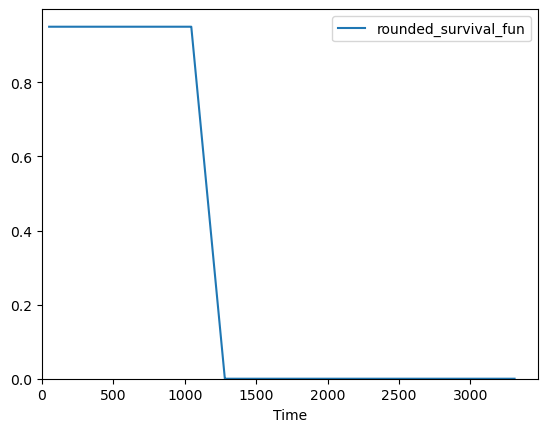

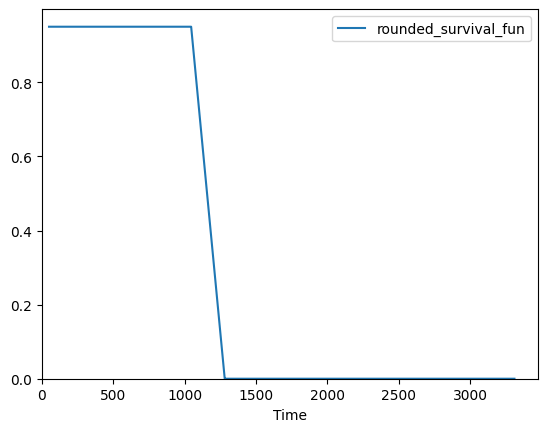

In [24]:
safe_plot = acro.surv_func(
    data.futime, data.death, output="plot", filename="kaplan-mier.png"
)
print(safe_plot)

# ACRO functionality to let users manage their outputs

### 1: List current ACRO outputs
This is an example of using the print_output function to list all the outputs created so far

In [25]:
acro.print_outputs()

uid: output_0
status: fail
type: table
properties: {'method': 'crosstab'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 4, 'p-ratio': 0, 'nk-rule': 0, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[2, 0], [2, 1], [2, 2], [4, 0]], 'p-ratio': [], 'nk-rule': [], 'all-values-are-same': []}}
command: safe_table = acro.crosstab(
summary: fail; threshold: 4 cells suppressed; 
outcome: parents      great_pret  pretentious        usual
recommend                                        
not_recom            ok           ok           ok
priority             ok           ok           ok
recommend   threshold;   threshold;   threshold; 
spec_prior           ok           ok           ok
very_recom  threshold;            ok           ok
output: [parents     great_pret  pretentious   usual
recommend                                  
not_recom       1440.0       1440.0  1440.0
priority         858.0       1484.0  1924.0
recommend     

'uid: output_0\nstatus: fail\ntype: table\nproperties: {\'method\': \'crosstab\'}\nsdc: {\'summary\': {\'suppressed\': True, \'negative\': 0, \'missing\': 0, \'threshold\': 4, \'p-ratio\': 0, \'nk-rule\': 0, \'all-values-are-same\': 0}, \'cells\': {\'negative\': [], \'missing\': [], \'threshold\': [[2, 0], [2, 1], [2, 2], [4, 0]], \'p-ratio\': [], \'nk-rule\': [], \'all-values-are-same\': []}}\ncommand: safe_table = acro.crosstab(\nsummary: fail; threshold: 4 cells suppressed; \noutcome: parents      great_pret  pretentious        usual\nrecommend                                        \nnot_recom            ok           ok           ok\npriority             ok           ok           ok\nrecommend   threshold;   threshold;   threshold; \nspec_prior           ok           ok           ok\nvery_recom  threshold;            ok           ok\noutput: [parents     great_pret  pretentious   usual\nrecommend                                  \nnot_recom       1440.0       1440.0  1440.0\npriori

### 2: Remove some ACRO outputs before finalising 
This is an example of deleting some of the ACRO outputs.  
The name of the output that needs to be removed should be passed to the function remove_output.  
- Currently, all outputs names contain timestamp; that is the time when the output was created.  
- The output name can be taken from the outputs listed by the print_outputs function, 
- or by listing the results and choosing the specific output that needs to be removed

In [26]:
acro.remove_output("output_0")

INFO:acro:records:remove(): output_0 removed


### 3: Rename ACRO outputs before finalising
This is an example of renaming the outputs to provide a more descriptive name.  
The timestamp associated with the output name will not get overwritten

In [27]:
acro.rename_output("output_2", "pivot_table")

INFO:acro:records:rename_output(): output_2 renamed to pivot_table


### 4: Add a comment to output
This is an example to add a comment to outputs.  
It can be used to provide a description or to pass additional information to the output checkers.

In [28]:
acro.add_comments("output_1", "Please let me have this data.")
acro.add_comments("output_1", "6 cells were suppressed in this table")

INFO:acro:records:a comment was added to output_1
INFO:acro:records:a comment was added to output_1


### 5: Add an unsupported output to the list of outputs
This is an example to add an unsupported outputs (such as images) to the list of outputs

In [29]:
acro.custom_output(
    "XandY.jpeg", "This output is an image showing the relationship between X and Y"
)

INFO:acro:records:add_custom(): output_13


## 6: (the big one) Finalise ACRO
This is an example of the function _finalise()_ which the users must call at the end of each session.  
- It takes each output and saves it to a CSV file.    
- It also saves the SDC analysis for each output to a json file or Excel file  
  (depending on the extension of the name of the file provided as an input to the function)

In [30]:
output = acro.finalise("NURSERY", "json")

INFO:acro:records:
uid: output_1
status: fail
type: table
properties: {'method': 'crosstab'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 5, 'p-ratio': 0, 'nk-rule': 0, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[2, 0], [2, 1], [2, 2], [2, 3], [4, 0]], 'p-ratio': [], 'nk-rule': [], 'all-values-are-same': []}}
command: safe_table = acro.crosstab(df.recommend, df.parents, margins=True)
summary: fail; threshold: 5 cells suppressed; 
outcome: parents      great_pret  pretentious        usual          All
recommend                                                     
not_recom            ok           ok           ok           ok
priority             ok           ok           ok           ok
recommend   threshold;   threshold;   threshold;   threshold; 
spec_prior           ok           ok           ok           ok
very_recom  threshold;            ok           ok           ok
All                  ok           ok      

 suppressed


INFO:acro:records:
uid: output_3
status: fail
type: table
properties: {'method': 'crosstab'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 1, 'p-ratio': 4, 'nk-rule': 4, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[2, 2]], 'p-ratio': [[2, 0], [2, 1], [2, 2], [4, 0]], 'nk-rule': [[2, 0], [2, 1], [2, 2], [4, 0]], 'all-values-are-same': []}}
command: safe_table = acro.crosstab(
summary: fail; threshold: 1 cells suppressed; p-ratio: 4 cells suppressed; nk-rule: 4 cells suppressed; 
outcome: parents             great_pret         pretentious  \
recommend                                            
not_recom                   ok                  ok   
priority                    ok                  ok   
recommend   p-ratio; nk-rule;   p-ratio; nk-rule;    
spec_prior                  ok                  ok   
very_recom  p-ratio; nk-rule;                   ok   

parents                             usual  
recommend    

 exception requested


INFO:acro:records:
uid: output_4
status: fail
type: table
properties: {'method': 'crosstab'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 2, 'p-ratio': 8, 'nk-rule': 8, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[2, 2], [2, 5]], 'p-ratio': [[2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [4, 0], [4, 3]], 'nk-rule': [[2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [4, 0], [4, 3]], 'all-values-are-same': []}}
command: safe_table = acro.crosstab(
summary: fail; threshold: 2 cells suppressed; p-ratio: 8 cells suppressed; nk-rule: 8 cells suppressed; 
outcome:                   mode_aggfunc                      \
parents             great_pret         pretentious   
recommend                                            
not_recom                   ok                  ok   
priority                    ok                  ok   
recommend   p-ratio; nk-rule;   p-ratio; nk-rule;    
spec_prior                  ok          

 exception requested


INFO:acro:records:
uid: output_6
status: fail
type: table
properties: {'method': 'pivot_table'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 5, 'p-ratio': 5, 'nk-rule': 5, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[0, 2], [0, 4], [1, 2], [2, 2], [3, 2]], 'p-ratio': [[0, 2], [0, 4], [1, 2], [2, 2], [3, 2]], 'nk-rule': [[0, 2], [0, 4], [1, 2], [2, 2], [3, 2]], 'all-values-are-same': []}}
command: safe_table = acro.pivot_table(
summary: fail; threshold: 5 cells suppressed; p-ratio: 5 cells suppressed; nk-rule: 5 cells suppressed; 
outcome:              children                                                     \
recommend   not_recom priority                      recommend spec_prior   
parents                                                                    
great_pret         ok       ok  threshold; p-ratio; nk-rule;          ok   
pretentious        ok       ok  threshold; p-ratio; nk-rule;          ok   
us

 some reason


INFO:acro:records:
uid: output_11
status: fail
type: table
properties: {'method': 'surv_func'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 76, 'p-ratio': 0, 'nk-rule': 0, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[1, 0], [1, 1], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [3, 3], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3], [6, 0], [6, 1], [6, 2], [6, 3], [7, 0], [7, 1], [7, 2], [7, 3], [8, 0], [8, 1], [8, 2], [8, 3], [9, 0], [9, 1], [9, 2], [9, 3], [10, 0], [10, 1], [10, 2], [10, 3], [11, 0], [11, 1], [11, 2], [11, 3], [12, 0], [12, 1], [12, 2], [12, 3], [13, 0], [13, 1], [13, 2], [13, 3], [14, 0], [14, 1], [14, 2], [14, 3], [15, 0], [15, 1], [15, 2], [15, 3], [16, 0], [16, 1], [16, 2], [16, 3], [17, 0], [17, 1], [17, 2], [17, 3], [18, 0], [18, 1], [18, 2], [18, 3], [19, 0], [19, 1], [19, 2], [19, 3]], 'p-ratio': [], 'nk-rule': [], 'all-values-are-same': []}}
comm

 some other reason


INFO:acro:records:
uid: output_12
status: fail
type: survival plot
properties: {'method': 'surv_func'}
sdc: {'summary': {'suppressed': True, 'negative': 0, 'missing': 0, 'threshold': 76, 'p-ratio': 0, 'nk-rule': 0, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[1, 0], [1, 1], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [3, 3], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3], [6, 0], [6, 1], [6, 2], [6, 3], [7, 0], [7, 1], [7, 2], [7, 3], [8, 0], [8, 1], [8, 2], [8, 3], [9, 0], [9, 1], [9, 2], [9, 3], [10, 0], [10, 1], [10, 2], [10, 3], [11, 0], [11, 1], [11, 2], [11, 3], [12, 0], [12, 1], [12, 2], [12, 3], [13, 0], [13, 1], [13, 2], [13, 3], [14, 0], [14, 1], [14, 2], [14, 3], [15, 0], [15, 1], [15, 2], [15, 3], [16, 0], [16, 1], [16, 2], [16, 3], [17, 0], [17, 1], [17, 2], [17, 3], [18, 0], [18, 1], [18, 2], [18, 3], [19, 0], [19, 1], [19, 2], [19, 3]], 'p-ratio': [], 'nk-rule': [], 'all-values-are-same': [

 suppressed


INFO:acro:records:
uid: pivot_table
status: fail
type: table
properties: {'method': 'crosstab'}
sdc: {'summary': {'suppressed': False, 'negative': 0, 'missing': 0, 'threshold': 4, 'p-ratio': 0, 'nk-rule': 0, 'all-values-are-same': 0}, 'cells': {'negative': [], 'missing': [], 'threshold': [[2, 0], [2, 1], [2, 2], [4, 0]], 'p-ratio': [], 'nk-rule': [], 'all-values-are-same': []}}
command: safe_table = acro.crosstab(df.recommend, df.parents)
summary: fail; threshold: 4 cells may need suppressing; 
outcome: parents      great_pret  pretentious        usual
recommend                                        
not_recom            ok           ok           ok
priority             ok           ok           ok
recommend   threshold;   threshold;   threshold; 
spec_prior           ok           ok           ok
very_recom  threshold;            ok           ok
output: [parents     great_pret  pretentious  usual
recommend                                 
not_recom         1440         1440   1440
pri

 a reason is provided


INFO:acro:records:
uid: output_13
status: review
type: custom
properties: {}
sdc: {}
command: custom
summary: review
outcome: Empty DataFrame
Columns: []
Index: []
output: ['XandY.jpeg']
timestamp: 2025-03-06T19:39:48.518030
comments: ['This output is an image showing the relationship between X and Y']
exception: 

The status of the record above is: review.
Please explain why an exception should be granted.



 image is not disclosive


INFO:acro:records:outputs written to: NURSERY


### 7: Add a directory of outputs to an acro object 
This is an example of adding a list of files (produced by the researcher without using ACRO) to an acro object and creates a results file for checking.

In [31]:
import shutil

table = pd.crosstab(df.recommend, df.parents)
# save the output table to a file and add this file to a directory
src_path = "test_add_to_acro"
file_path = "crosstab.pkl"
dest_path = "SDC_results"
if not os.path.exists(src_path):
    table.to_pickle(file_path)
    os.mkdir(src_path)
    shutil.move(file_path, src_path, copy_function=shutil.copytree)

# add the output to acro
add_to_acro(src_path, dest_path)

INFO:acro:version: 0.4.8
INFO:acro:config: {'safe_threshold': 10, 'safe_dof_threshold': 10, 'safe_nk_n': 2, 'safe_nk_k': 0.9, 'safe_pratio_p': 0.1, 'check_missing_values': False, 'survival_safe_threshold': 10, 'zeros_are_disclosive': True}
INFO:acro:automatic suppression: False
INFO:acro:records:add_custom(): output_0
INFO:acro:records:rename_output(): output_0 renamed to crosstab.pkl
INFO:acro:records:
uid: crosstab.pkl
status: review
type: custom
properties: {}
sdc: {}
command: custom
summary: review
outcome: Empty DataFrame
Columns: []
Index: []
output: ['test_add_to_acro/crosstab.pkl']
timestamp: 2025-03-06T19:41:22.128464
comments: ['']
exception: 

The status of the record above is: review.
Please explain why an exception should be granted.



 pickle file need some explanation 


INFO:acro:records:outputs written to: SDC_results
